# Example usage

To use `simsvi` in a project:

In [5]:
import simsvi
import pandas as pd

print(simsvi.__version__)

0.1.0


In [6]:
parameters_list = []
for tree_change in [-0.1]:
    parameters_list.append({
        'tree_ratio': 0.5,
        'tree_change': [tree_change],
        'camera_position_range': 1,
        'seed': 1,
        'dir_plot': f'figures/tree_change_{str(tree_change)}'
    })
greenery_dict_list = simsvi.run_multiple_simulations(parameters_list, max_workers=10)

Running simulations: 100%|██████████| 1/1 [00:18<00:00, 18.59s/it]


In [2]:
# test the following parameters
# tree_change: [-0.1], [-0.2], [-0.3], [-0.4], [-0.5], [-0.6], [-0.7], [-0.8], [-0.9], [-1]
# camera_position_range: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
# seed: range(100)
parameters_list = []
for tree_change in [-0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1]:
    for camera_position_range in range(1, 8):
        for seed in range(100):
            parameters_list.append({
                'tree_ratio': 0.5,
                'tree_change': [tree_change],
                'camera_position_range': camera_position_range,
                'months_of_interest': [7],
                'seed': seed
            })
greenery_dict_list = simsvi.run_multiple_simulations(parameters_list, max_workers=10)
# convert the results to df
greenery_df = pd.DataFrame(greenery_dict_list)
# save the results to a csv file
greenery_df.to_csv('docs/greenery_results.csv', index=False)

Running simulations: 100%|██████████| 7000/7000 [00:52<00:00, 134.48it/s]


In [3]:
def plot_greenery_results(greenery_df, output_file, tree_change, camera_position_range):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    # plot the results
    fig, ax = plt.subplots()
    # use violin plot to show the distribution of diff column
    sns.violinplot(x='year', y='green_view_index', data=greenery_df, ax=ax)
    ax.set_xlabel('Year')
    ax.set_ylabel('Green View Index')
    ax.set_title(f'Green View Index Distribution\nTree Change: {tree_change}, Camera Position Range: {camera_position_range}')
    # save the plot
    fig.savefig(output_file)
    # close
    plt.close(fig)

def run_t_test(greenery_df):
    # run single sample t-test to see if the mean greenery is significantly different from 0
    greenery_mean = greenery_df['diff'].mean()
    # run t-test
    from scipy.stats import ttest_1samp
    t_stat, p_value = ttest_1samp(greenery_df['0, alternative='less')
    return greenery_mean, t_stat, p_value

/var/folders/bg/91sx9x5x33j4mhkjd6nhgkdc0000gn/T/ipykernel_13725/3336023062.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


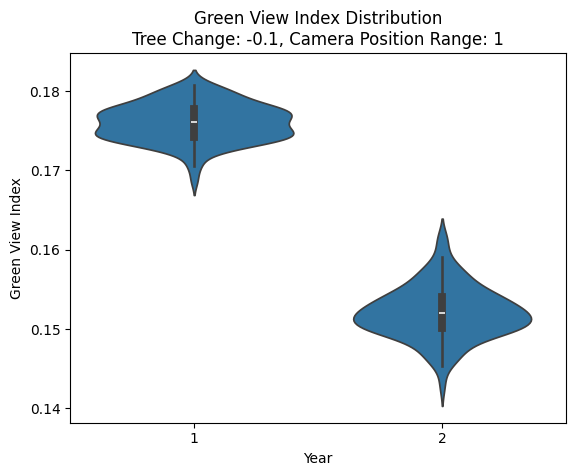

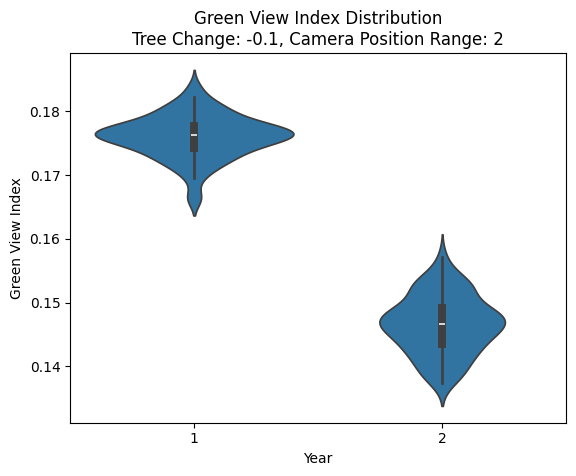

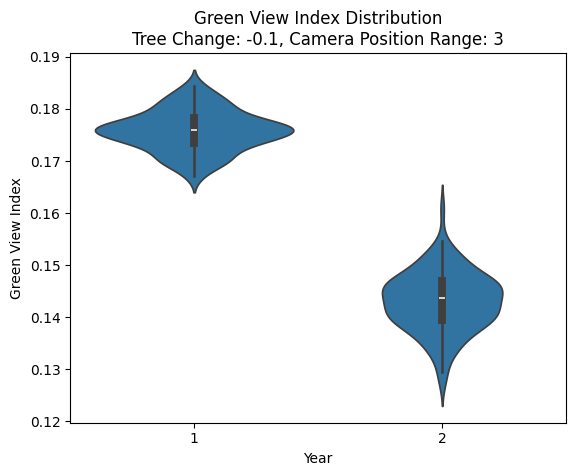

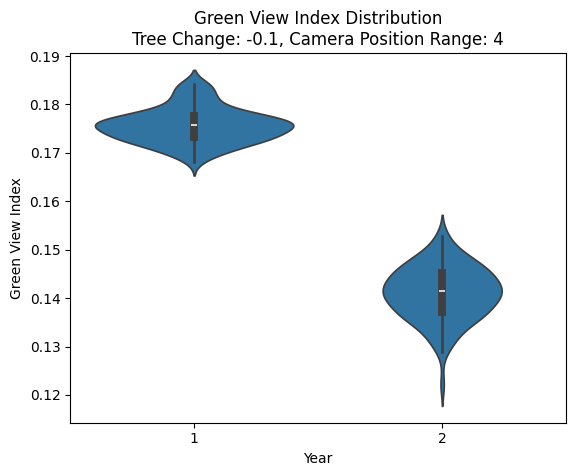

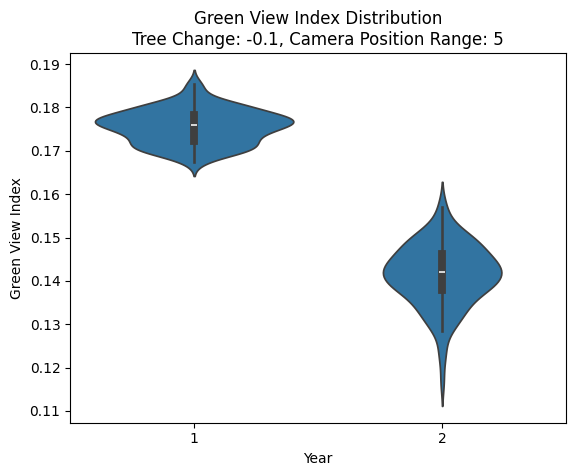

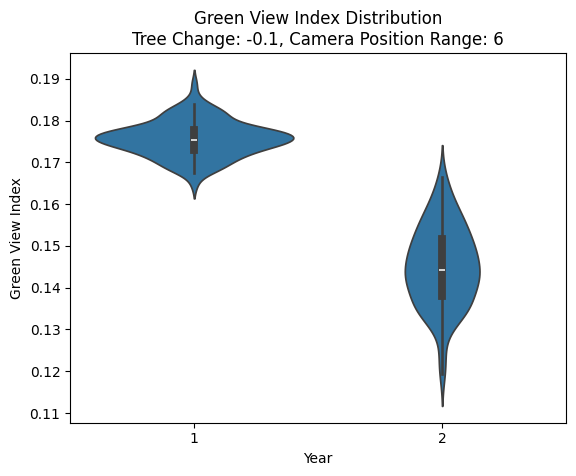

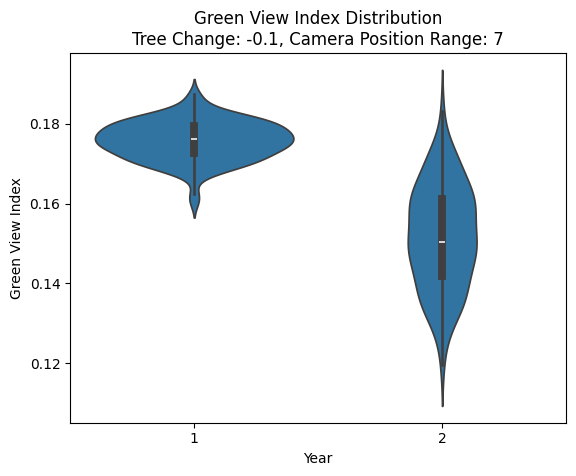

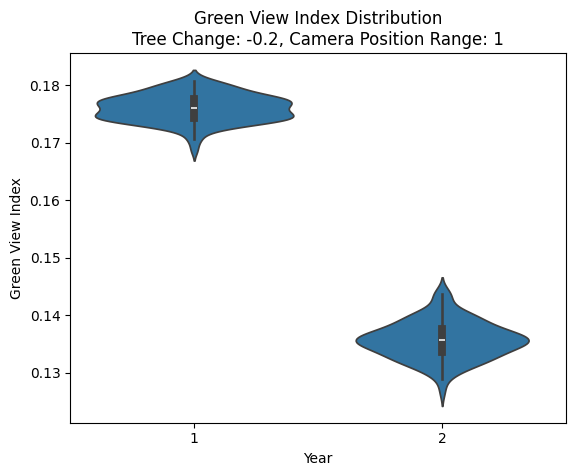

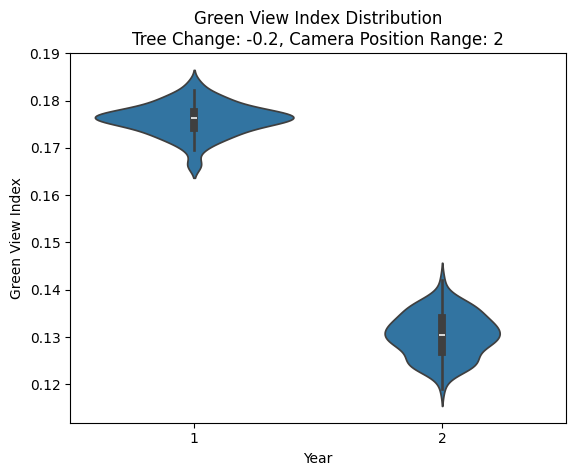

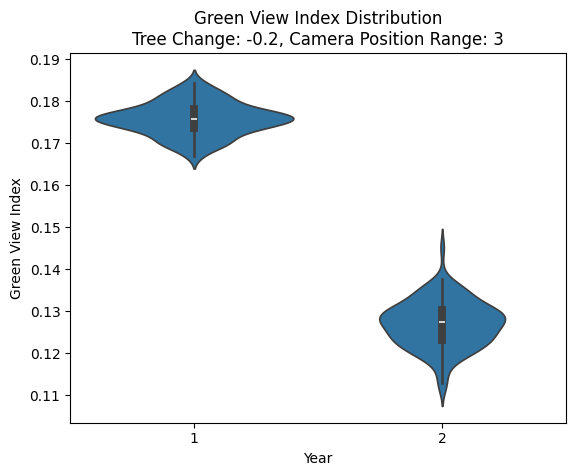

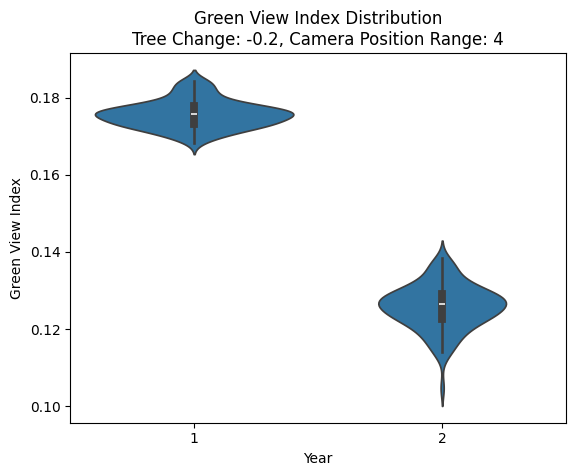

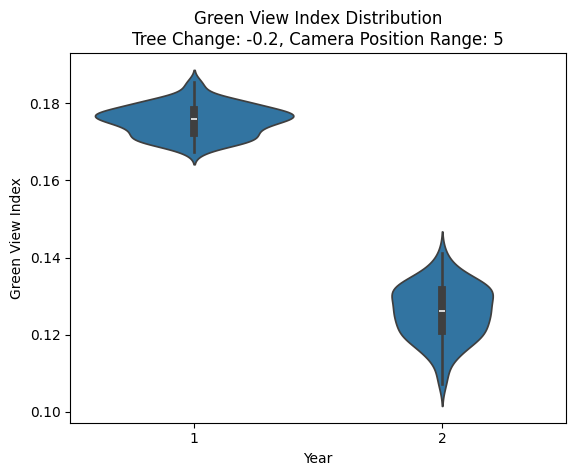

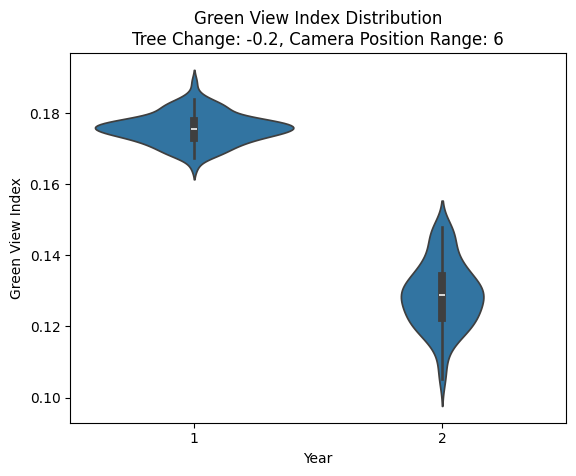

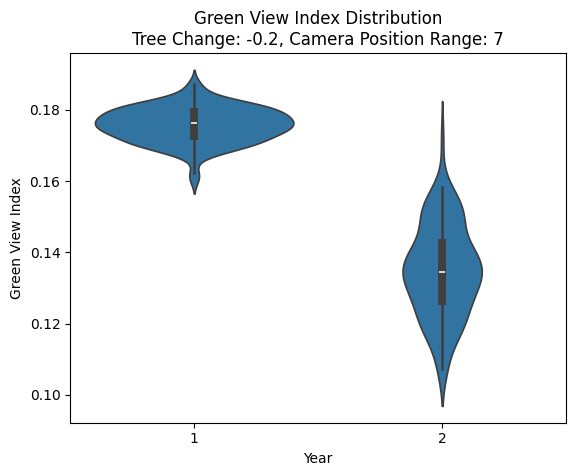

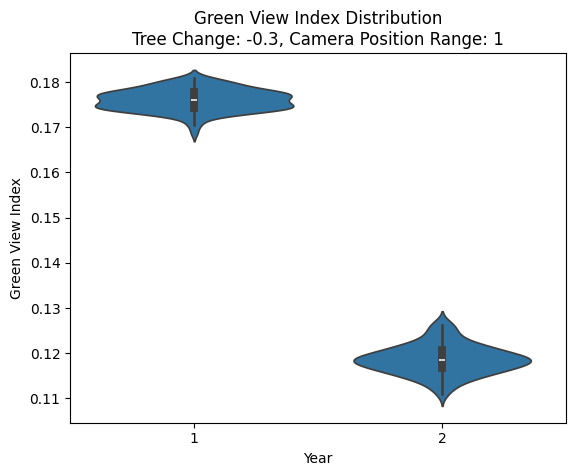

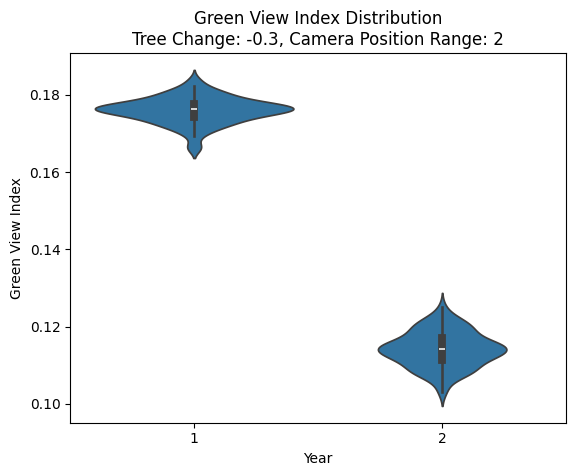

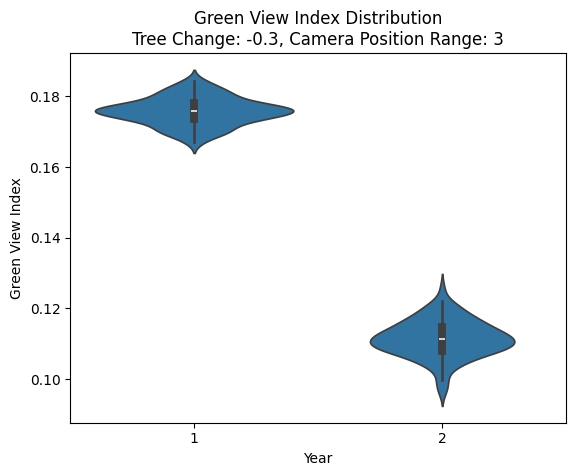

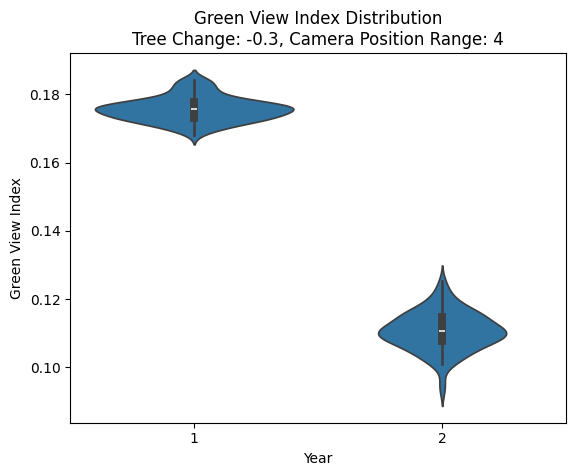

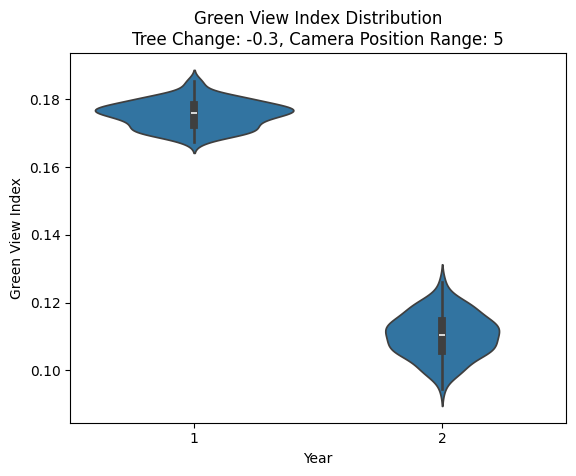

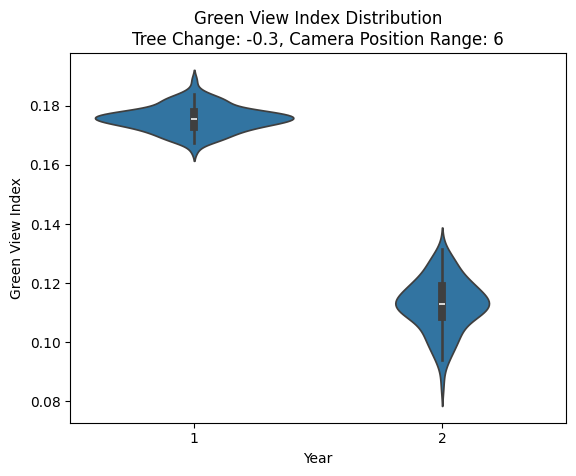

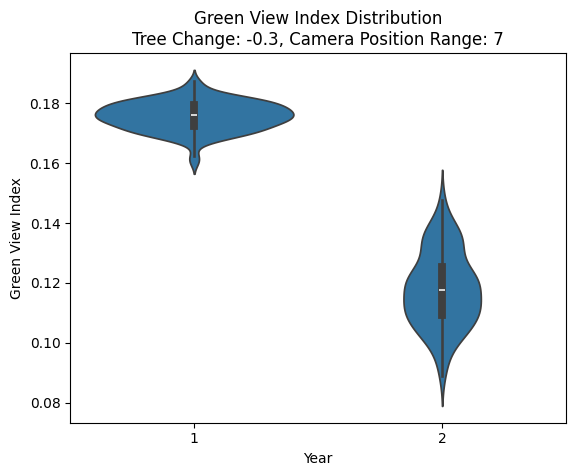

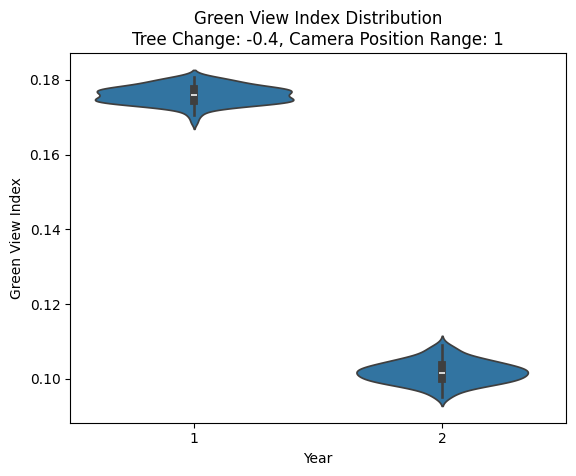

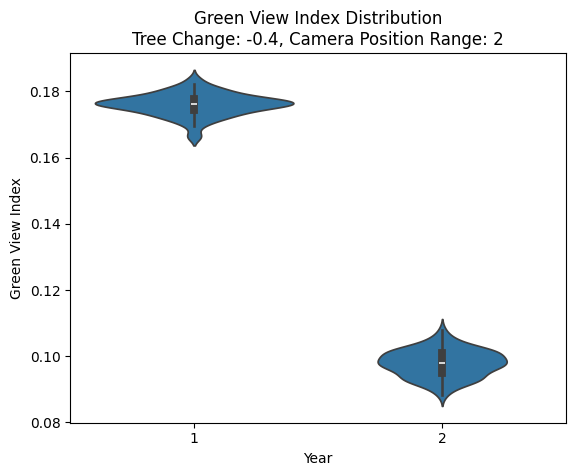

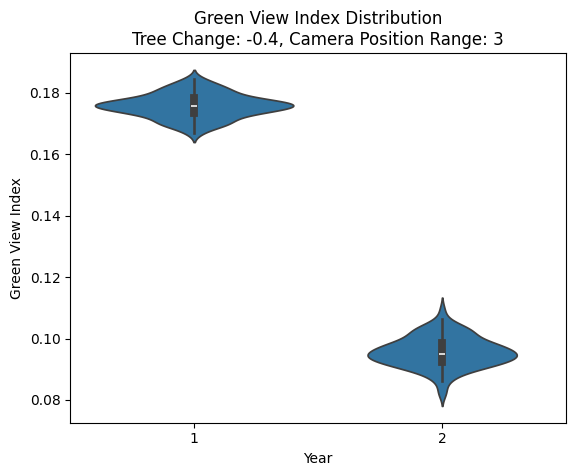

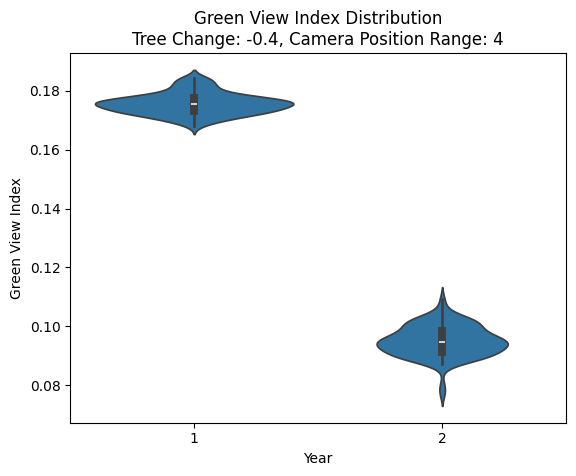

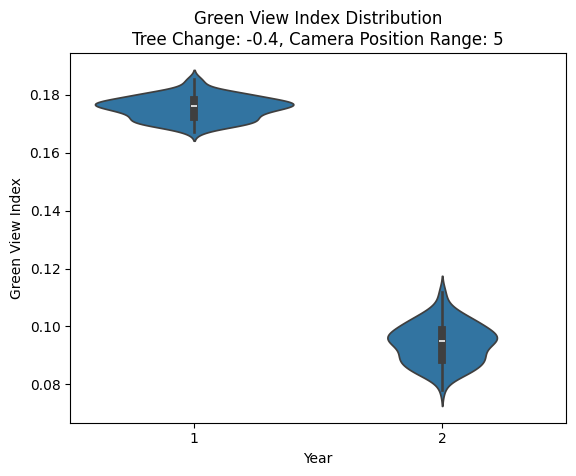

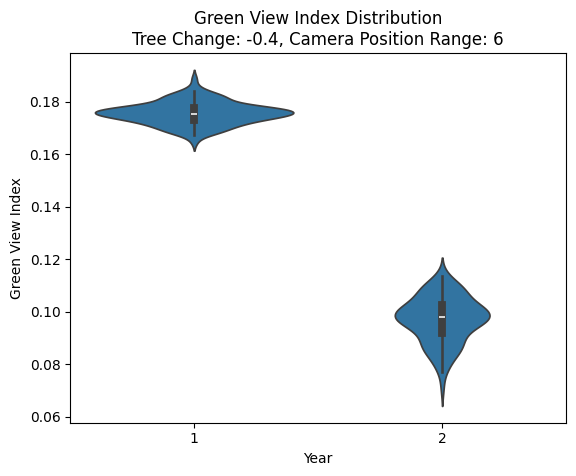

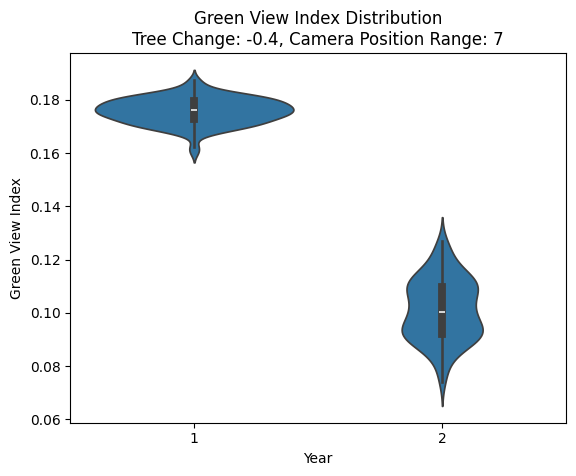

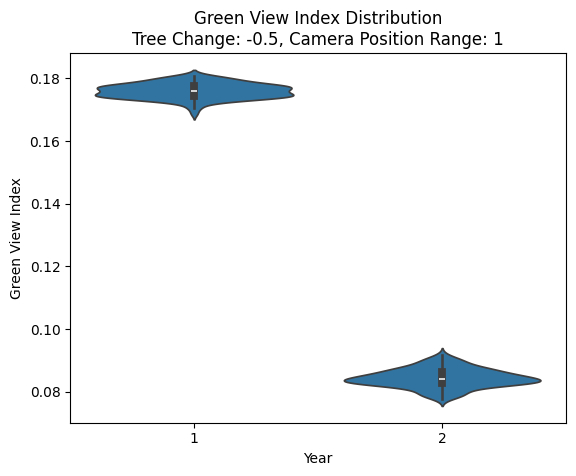

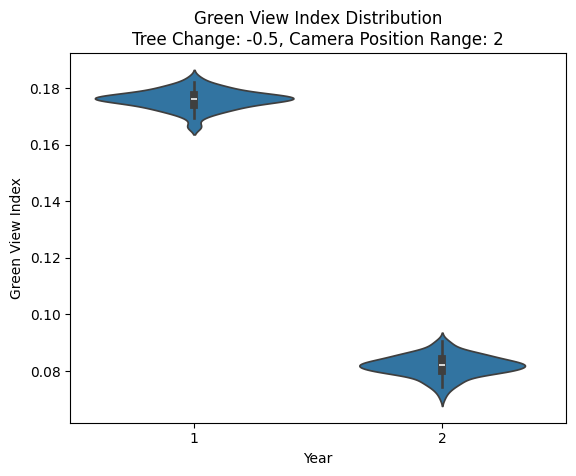

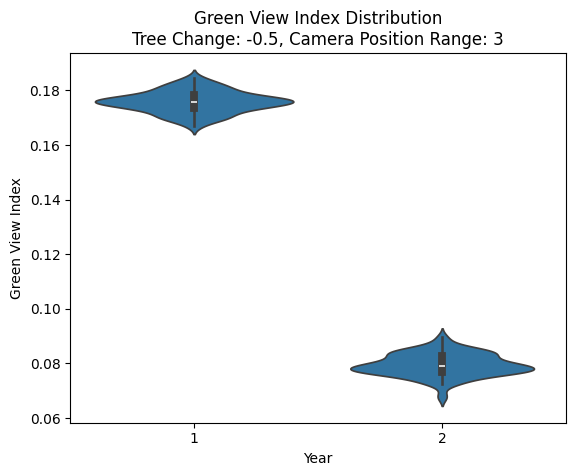

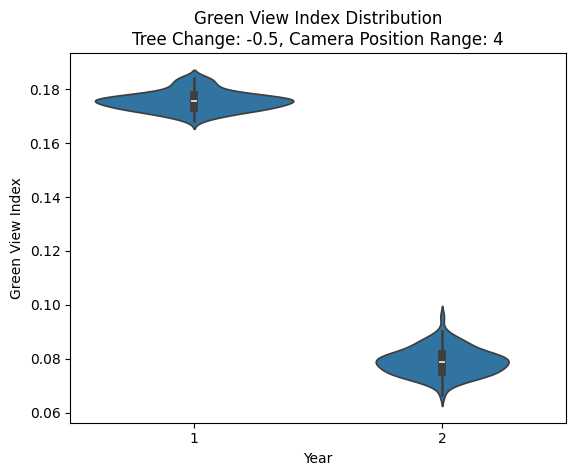

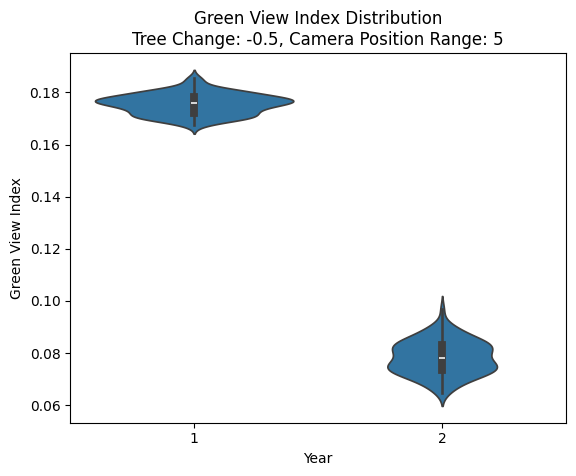

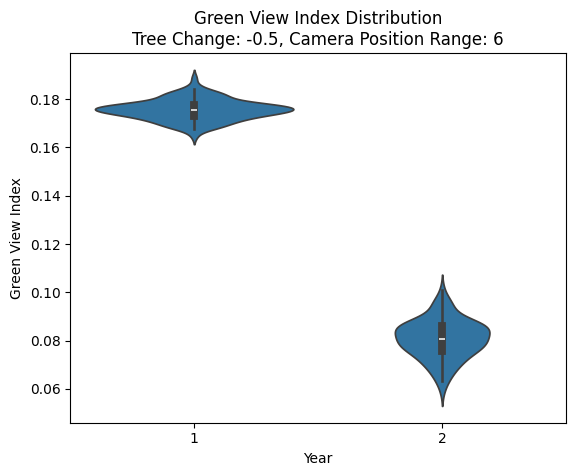

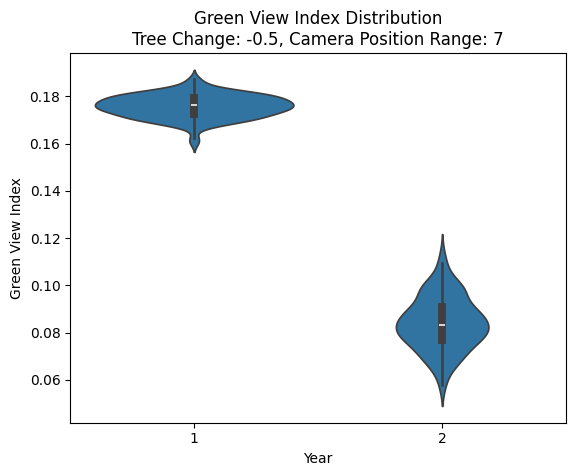

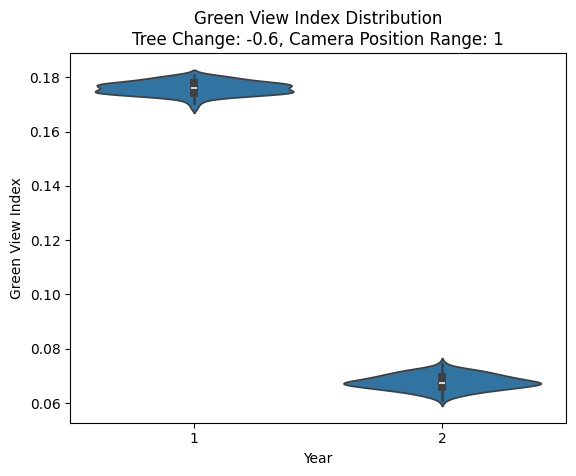

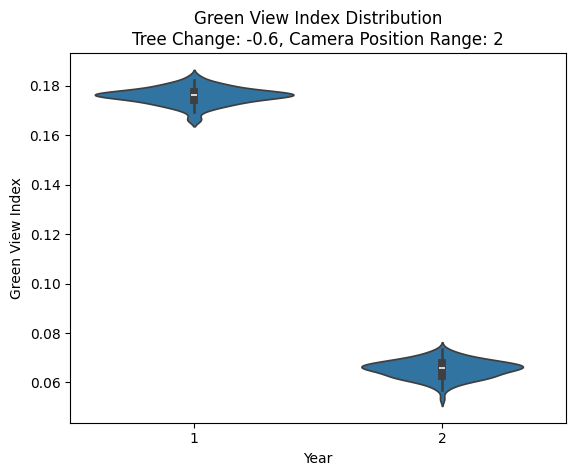

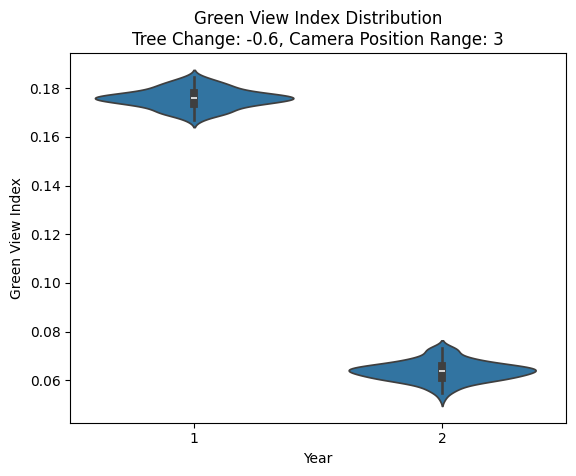

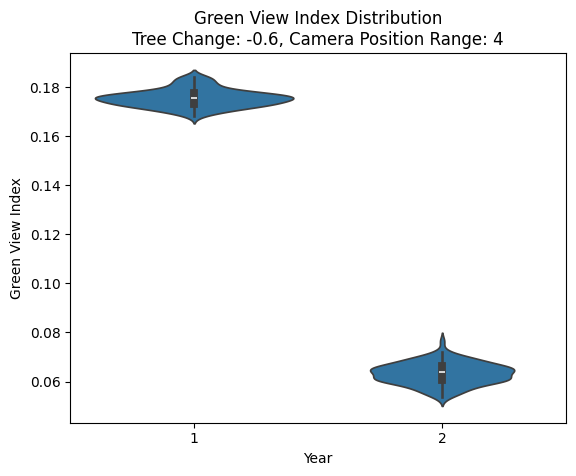

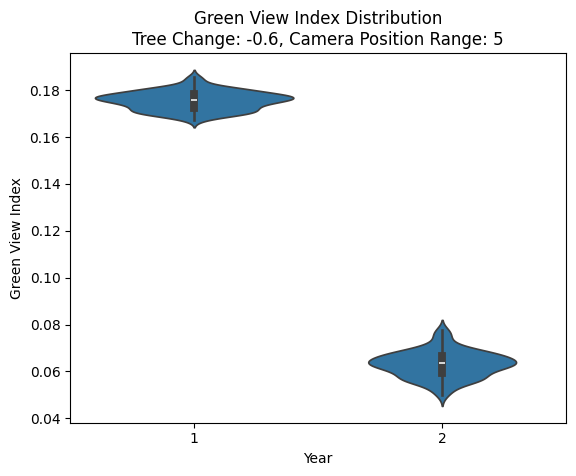

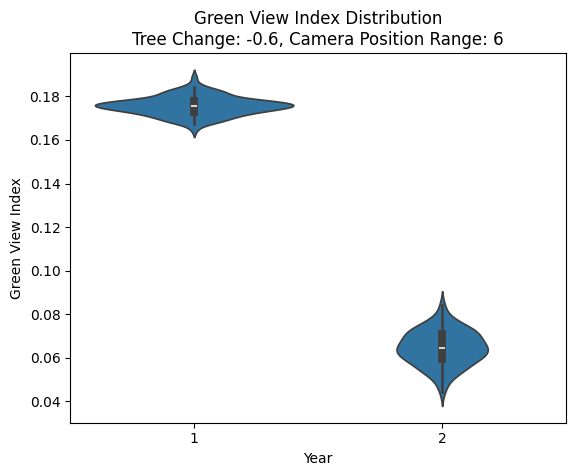

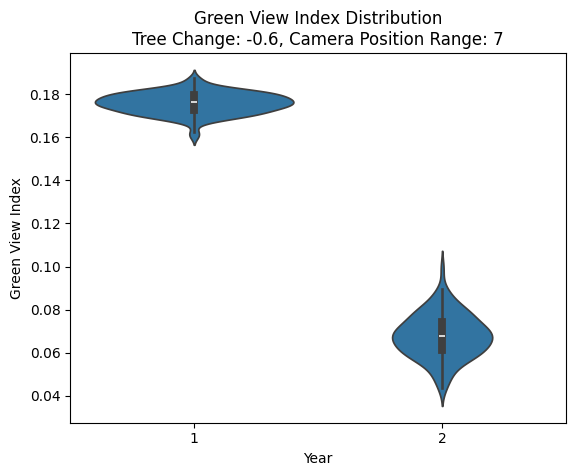

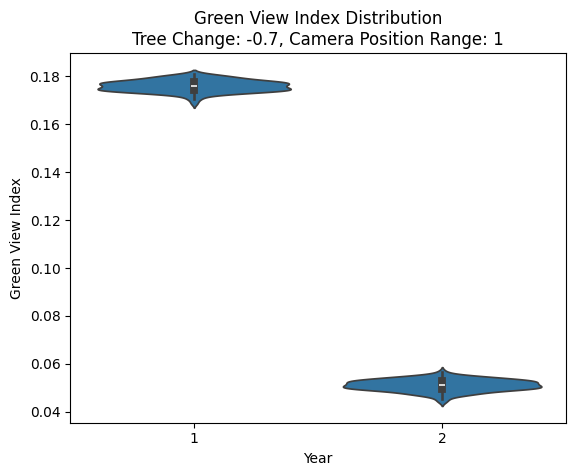

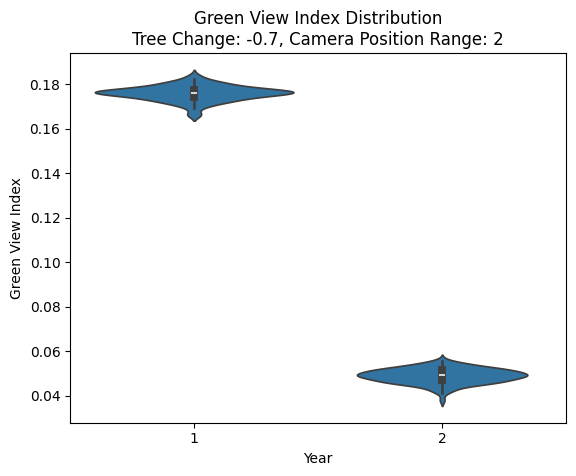

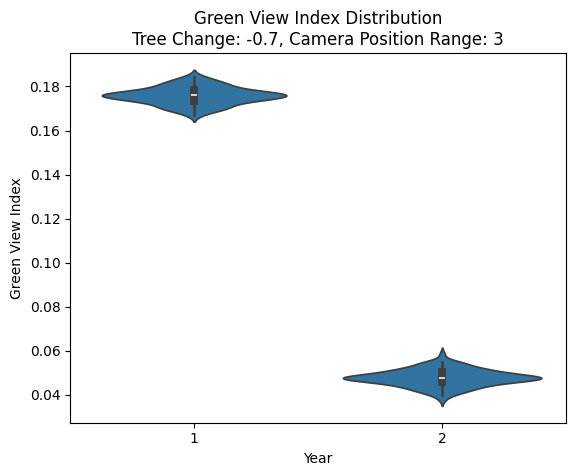

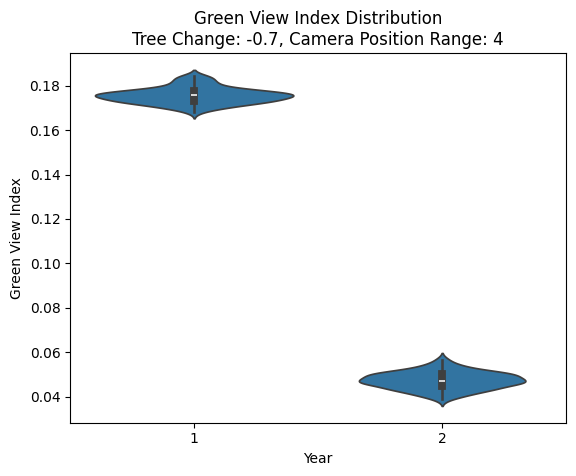

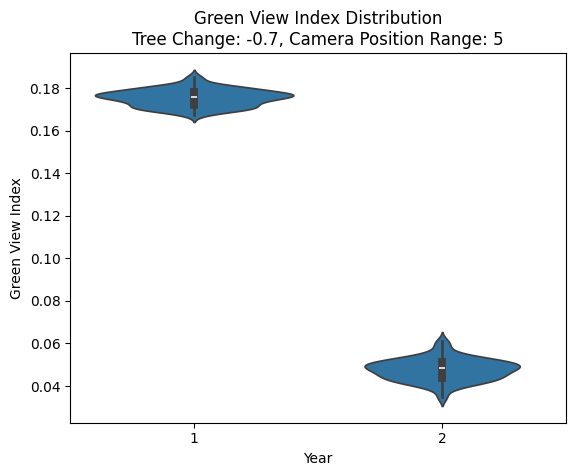

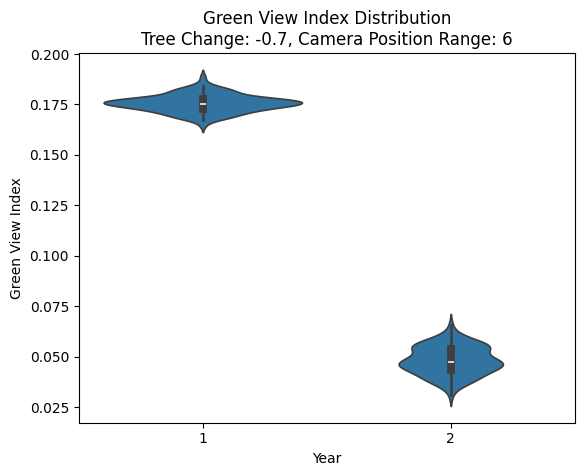

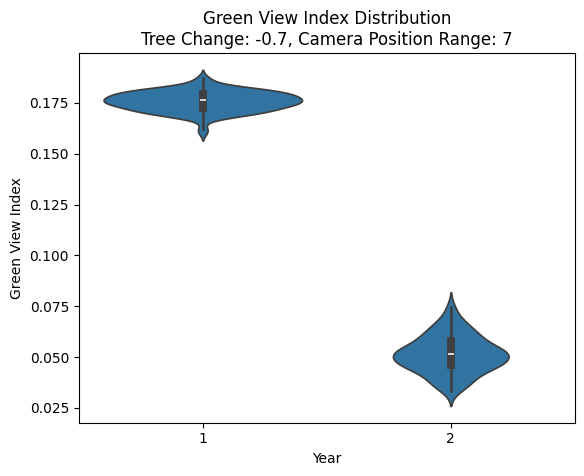

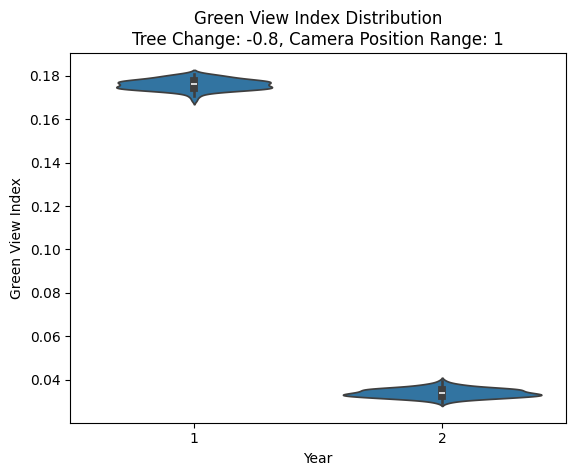

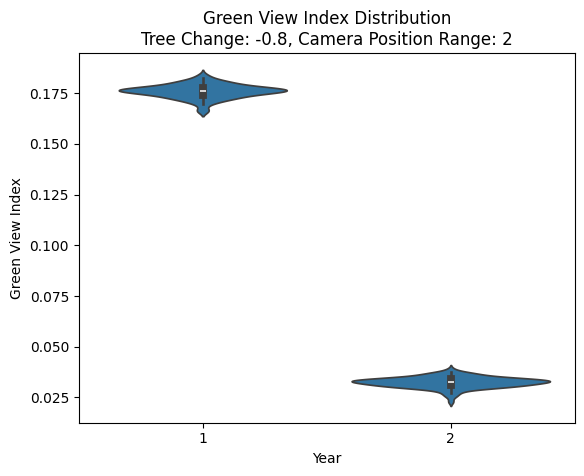

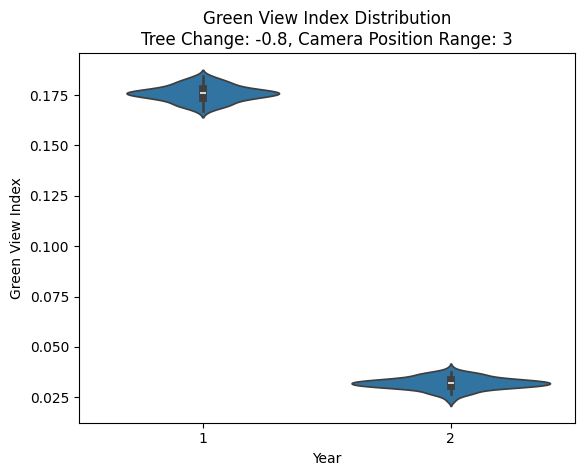

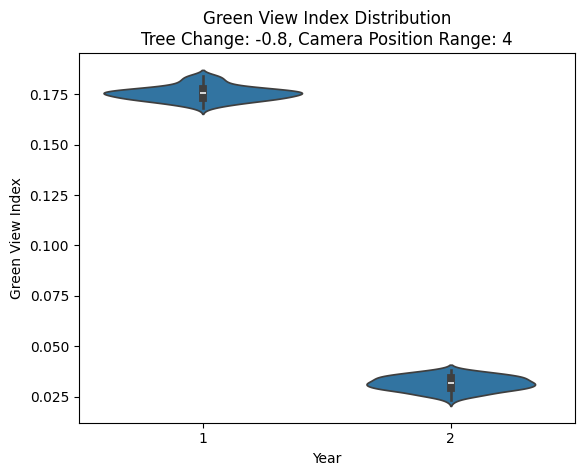

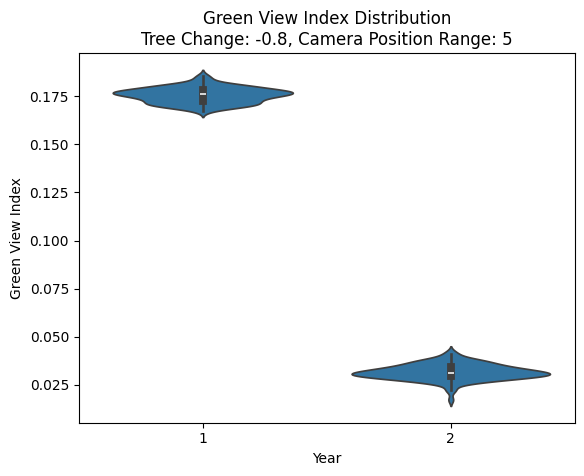

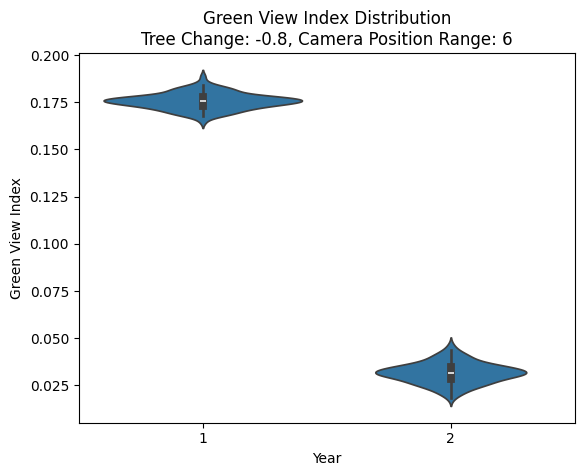

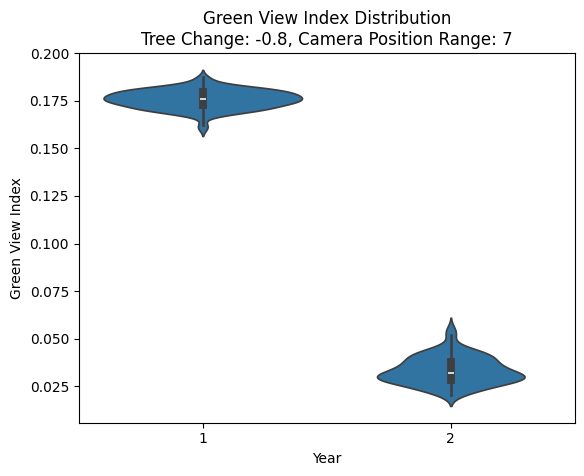

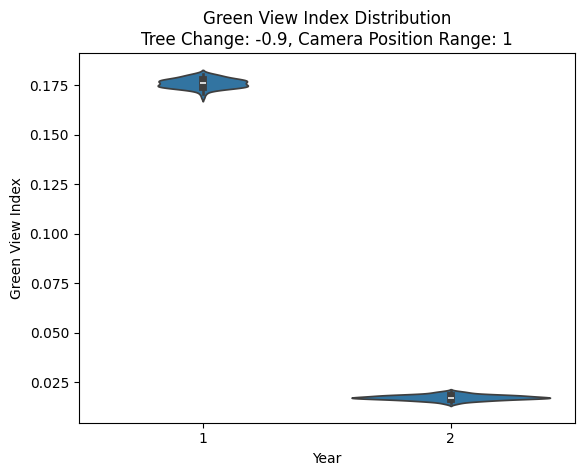

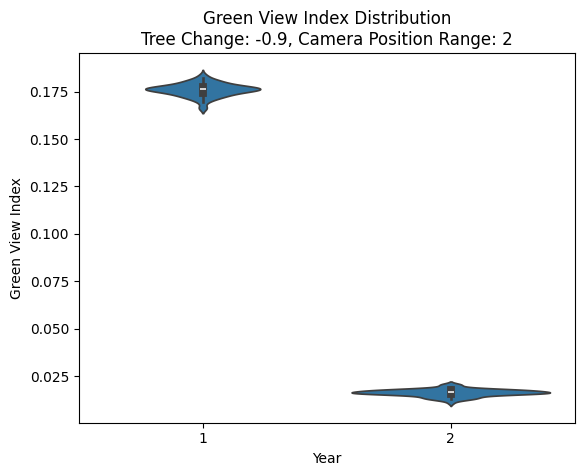

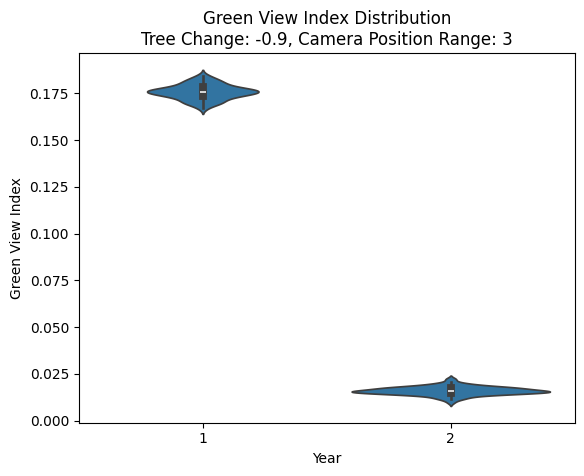

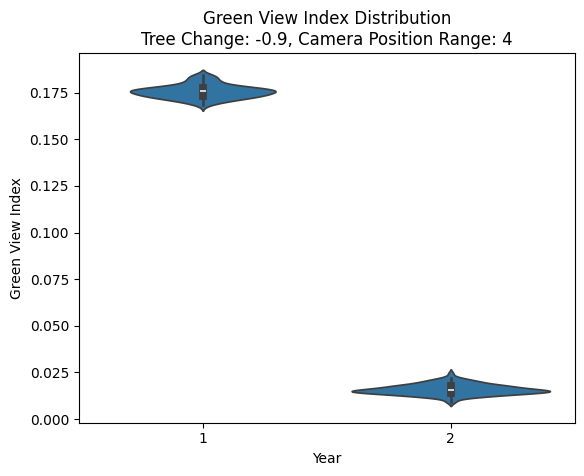

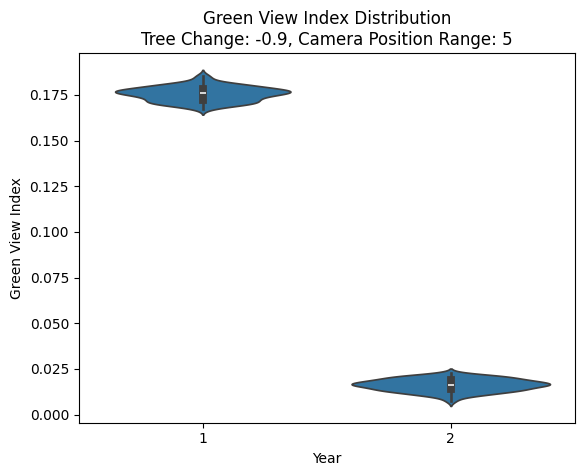

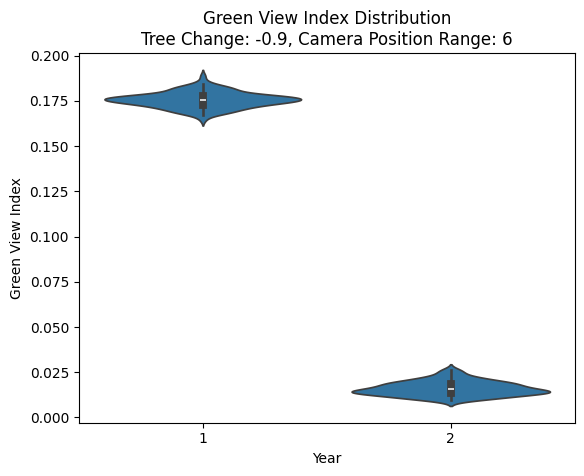

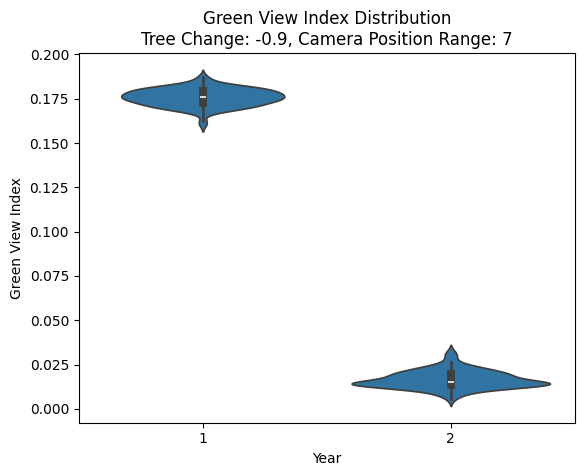

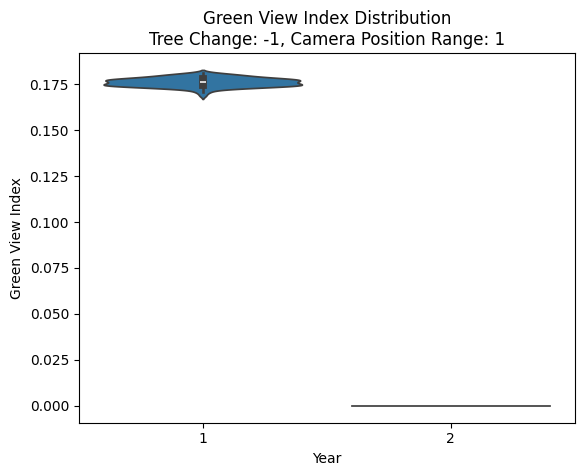

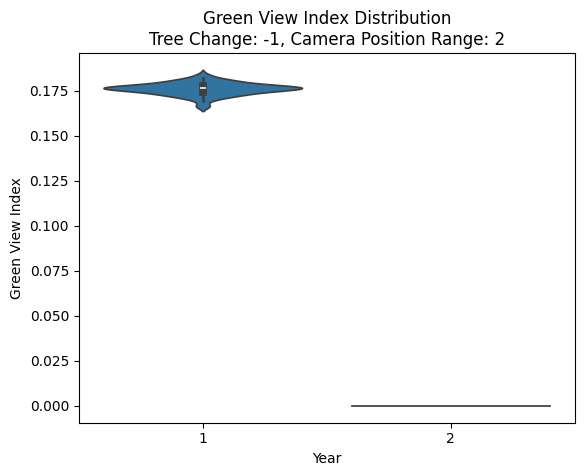

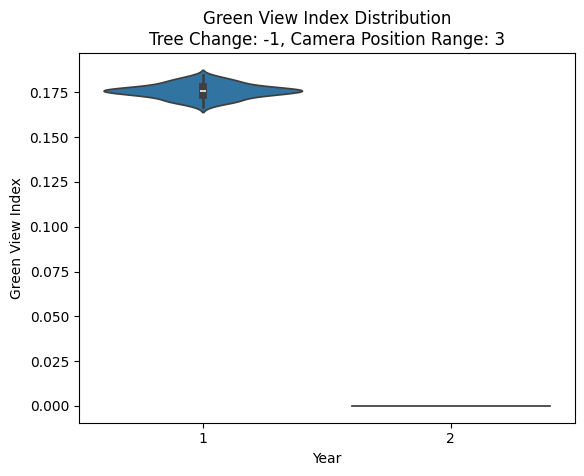

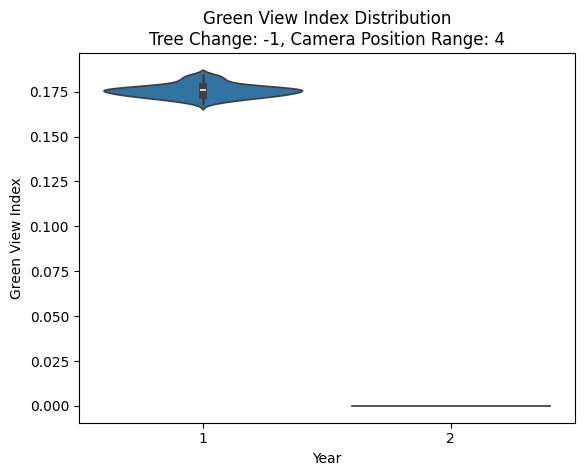

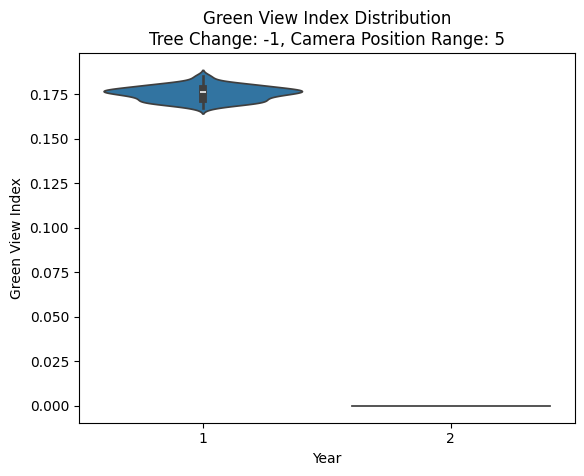

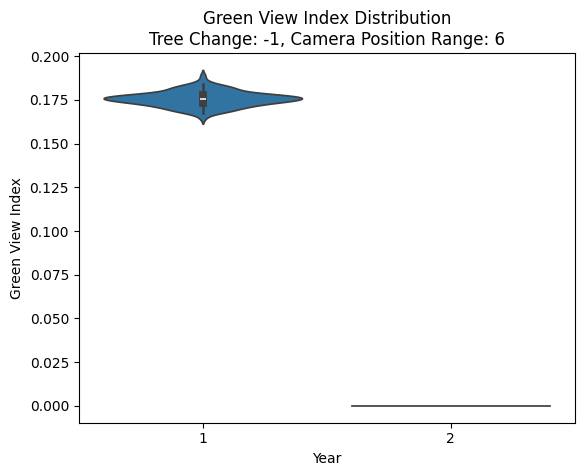

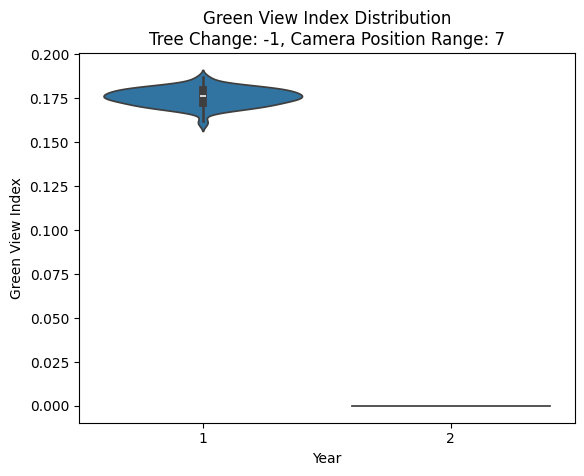

In [8]:
# conduct statistical analysis
greenery_df = pd.read_csv('docs/greenery_results.csv')
t_test_results_list = []
for tree_change in [-0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1]:
    for camera_position_range in range(1, 8):
        # filter the results
        filtered_df = greenery_df[(greenery_df['tree_change'] == f"[{tree_change}]") & (greenery_df['camera_position_range'] == camera_position_range)]
        # get the mean camera_postion_y and min camera_position_x
        camera_position_y_mean = filtered_df['camera_position_y'].mean()
        camera_position_x_mean = filtered_df['camera_position_x'].mean()
        camera_position_y_min = filtered_df['camera_position_y'].min()
        camera_position_x_min = filtered_df['camera_position_x'].min()
        # filter filtered_df to only include the results with the mean camera_position_y and min camera_position_x in year 1 and
        # camera_position_x_mean and camera_position_y_mean in year 2
        filtered_df = filtered_df[
            ((filtered_df['camera_position_y'] == camera_position_y_mean) & (filtered_df['camera_position_x'] == camera_position_x_mean)) & (filtered_df['year'] == 1)|
            ((filtered_df['camera_position_y'] == camera_position_y_min) & (filtered_df['camera_position_x'] == camera_position_x_min)) & (filtered_df['year'] == 2)
        ]
        # convert to wide format
        wide_df = filtered_df.pivot(index='seed', columns='year', values='green_view_index')
        # calculate the difference between year 1 and year 2
        if 2 not in wide_df.columns:
            print(filtered_df)
        wide_df['diff'] = wide_df[2] - wide_df[1]
        # run t-test (single sample t-test)
        greenery_mean, t_stat, p_value = run_t_test(wide_df)
        # append the results to t_test_results_list
        t_test_results_list.append({
            'tree_change': tree_change,
            'camera_position_range': camera_position_range,
            'greenery_mean': greenery_mean,
            't_stat': t_stat,
            'p_value': p_value,
            'significant': p_value < 0.05,
        })
        # plot the results
        output_file = f'figures/tree_change_{tree_change}_camera_position_range_{camera_position_range}.png'
        plot_greenery_results(filtered_df, output_file, tree_change, camera_position_range)
# convert the results to df and save to a csv file
t_test_results_df = pd.DataFrame(t_test_results_list)
t_test_results_df.to_csv('docs/t_test_results.csv', index=False)

In [ ]:
greenery_df

,seed,size,green_max,green_min,road_width,tree_ratio,camera_position_range,hot_month,cold_month,tree_change,dir_plot,year,month,camera_position_x,camera_position_y,green_view_index
0,92,31,1,0,0.5,0.5,3,7,1,[-0.1],False,1,7,15,12,1.775584
1,92,31,1,0,0.5,0.5,3,7,1,[-0.1],False,1,7,15,13,1.744162
2,92,31,1,0,0.5,0.5,3,7,1,[-0.1],False,1,7,15,14,1.728736
3,92,31,1,0,0.5,0.5,3,7,1,[-0.1],False,1,7,15,15,1.728000
4,92,31,1,0,0.5,0.5,3,7,1,[-0.1],False,1,7,15,16,1.741773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3539995,97,31,1,0,0.5,0.5,10,7,1,[-1],False,2,7,35,21,0.000000
3539996,97,31,1,0,0.5,0.5,10,7,1,[-1],False,2,7,35,22,0.000000
3539997,97,31,1,0,0.5,0.5,10,7,1,[-1],False,2,7,35,23,0.000000
3539998,97,31,1,0,0.5,0.5,10,7,1,[-1],False,2,7,35,24,0.000000
